In [1]:
import pprint

import numpy as np
import lightgbm as lgb

from otb.tasks import TaskApi
from otb.plot import plot_predictions

In [2]:
pprinter = pprint.PrettyPrinter(indent=4, width=120, compact=True)

### load the tasks

In [3]:
task_api = TaskApi()

In [4]:
task = task_api.get_task("regression.mlo_cn2.dropna.Cn2_15m")

The `task` object gives access to the description and associated metadata surrounding the task.

In [5]:
task_info = task.get_info()
pprinter.pprint(task_info)

{   'description': 'Regression task for MLO Cn2 data, where the last 12 days are set aside for evaluation',
    'description_long': 'This dataset evaluates regression approaches for predicting the extent of optical turbulence, '
                        'as measured by Cn2 at an elevation of 15m. Optical turbulence on data collected at the Mauna '
                        'Loa Solar Observatory between 27 July 2006 and 8 August 2006, inclusive, are used to evaluate '
                        'prediction accuracy under the root-mean square error metric.',
    'dropna': True,
    'ds_name': 'mlo_cn2',
    'eval_metrics': ['root_mean_square_error', 'r2_score', 'mean_absolute_error', 'mean_absolute_percentage_error'],
    'log_transform': True,
    'obs_lat': 19.53,
    'obs_lon': -155.57,
    'obs_tz': 'US/Hawaii',
    'remove': ['base_time', 'Cn2_6m', 'Cn2_15m', 'Cn2_25m'],
    'target': 'Cn2_15m',
    'test_idx': ['10367:13943'],
    'train_idx': ['0:8367'],
    'val_idx': ['8367:10367']}


As seen above, the `regression.mlo_cn2.dropna.Cn2_15m` task is focused on predicting the optical turbulence strength at a height of 15 \[m\] at the Mauna Loa Observatory (MLO) in Hawaii. The task uses the `mlo_cn2` dataset, which is a dataset of optical turbulence strength measurements at the MLO. The `task` contains an `obs_tz` attribute which specifies the timezone of the observatory. The latitude and longitude of the observatory are also provided as `obs_lat` and `obs_lon` attributes.

The `task` also contains a `target` attribute which specifies the target feature for the task. The task is focused on predicting the optical turbulence strength at a height of 15 \[m\], and the optical turbulence strength measurements at heights of 6 and 25 \[m\] are assumed to be unavailable for training or inference.

To ensure consistency and robust comparison between modeling approaches, the `train_idx`, `test_idx`, and `val_idx` are fixed for the given task. The `train_idx` and `val_idx` attributes specify the indices of the dataset which are available for model development. The `test_idx` attribute specifies the indices of the dataset which are used to evaluate the model during and compare against existing benchmarks for the task.

The task is evaluated using the root mean squared error (RMSE), explained variance score (EVS), mean absolute error (MAE), and mean absolute percentage error (MAPE) metrics. The task is evaluated on the test and validation splits of the dataset, and the training split is used for training new models.

Get the training data

In [6]:
X_train, y_train = task.get_train_data(data_type="pd")

Define your model

In [7]:
model = lgb.LGBMRegressor()

Once we have defined the model, we can use the training data provided by the task API (`X_train` and `y_train`).


In [8]:
model.fit(X_train, y_train)

LGBMRegressor()

We can tune hyper parameters using the validation data provided by the task API (`X_val` and `y_val`). In this case, we move directly to evaluation on the test set for our regression task.

Evaluate your model

In [9]:
task.evaluate_model(predict_call=model.predict)

{'root_mean_square_error': {'metric_value': 0.21550584034473647,
  'valid_predictions': 2449},
 'r2_score': {'metric_value': 0.8936031659084048, 'valid_predictions': 2449},
 'mean_absolute_error': {'metric_value': 0.15718607854371786,
  'valid_predictions': 2449},
 'mean_absolute_percentage_error': {'metric_value': 0.011320035736497307,
  'valid_predictions': 2449}}

The `otb` package includes benchmarks for the models defined in the `otb.benchmark.models` module. Each task can access the evaluation results for the benchmark models using the `get_benchmark_results` method.

Compare against benchmarks

In [10]:
benchmarks = task.get_benchmark_info()

In [11]:
pprinter.pprint(benchmarks)

{   'ClimatologyRegressionModel': {   'mean_absolute_error': {   'metric_value': 0.5308192372322083,
                                                                 'valid_predictions': 2449},
                                      'mean_absolute_percentage_error': {   'metric_value': 0.038418691605329514,
                                                                            'valid_predictions': 2449},
                                      'r2_score': {'metric_value': -0.001476310741173048, 'valid_predictions': 2449},
                                      'root_mean_square_error': {   'metric_value': 0.6611728668212891,
                                                                    'valid_predictions': 2449}},
    'GradientBoostingRegressionModel': {   'mean_absolute_error': {   'metric_value': 0.15414540847947156,
                                                                      'valid_predictions': 2449},
                                           'mean_absolute_percen

We can easily access the top two existing models using the `top_models` method of the `task`.

In [12]:
top_2_models = task.top_models(n=2, metric="mean_absolute_percentage_error")

In [13]:
pprinter.pprint(top_2_models)

{   'GradientBoostingRegressionModel': {   'mean_absolute_error': {   'metric_value': 0.15414540847947156,
                                                                      'valid_predictions': 2449},
                                           'mean_absolute_percentage_error': {   'metric_value': 0.011118891476548967,
                                                                                 'valid_predictions': 2449},
                                           'r2_score': {'metric_value': 0.8970294513678981, 'valid_predictions': 2449},
                                           'root_mean_square_error': {   'metric_value': 0.21200749028200058,
                                                                         'valid_predictions': 2449}},
    'MinuteClimatologyRegressionModel': {   'mean_absolute_error': {   'metric_value': 0.3842025101184845,
                                                                       'valid_predictions': 2449},
                             

Our model performs better than some existing benchmarks, and we can programmatically add it to the `experiments.json` file for future comparison.

In [14]:
_ = task.evaluate_model(
        predict_call=model.predict,
        include_as_benchmark=True,
        model_name="lgbm",
    )

Let's validate that this new model is included in our benchmark results.

In [15]:
top_3_models = task.top_models(n=3, metric="mean_absolute_percentage_error")

In [16]:
pprinter.pprint(top_3_models)

{   'GradientBoostingRegressionModel': {   'mean_absolute_error': {   'metric_value': 0.15414540847947156,
                                                                      'valid_predictions': 2449},
                                           'mean_absolute_percentage_error': {   'metric_value': 0.011118891476548967,
                                                                                 'valid_predictions': 2449},
                                           'r2_score': {'metric_value': 0.8970294513678981, 'valid_predictions': 2449},
                                           'root_mean_square_error': {   'metric_value': 0.21200749028200058,
                                                                         'valid_predictions': 2449}},
    'MinuteClimatologyRegressionModel': {   'mean_absolute_error': {   'metric_value': 0.3842025101184845,
                                                                       'valid_predictions': 2449},
                             

In addition to computing metrics and comparing with existing benchmarks, the `evaluate_model` method of the `task` can be used to return the model's predictions on the test. This can be used to visualize the model's performance, as well as to investigate trends in prediction error.

In [17]:
_, y_test = task.get_test_data(data_type='pd')
_, y_pred = task.evaluate_model(model.predict, return_predictions=True)

We can inspect these predictions visually using the `plot_predictions` method.

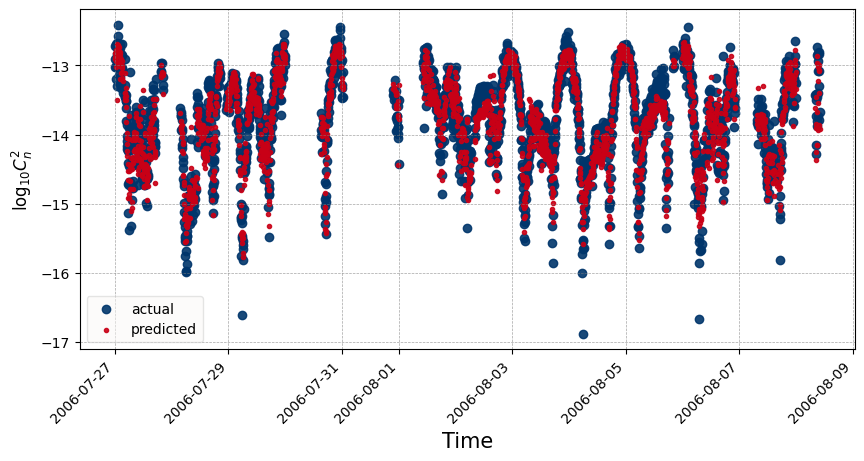

In [18]:
fig, ax = plot_predictions(y_test, y_pred)

Returning to our `PersistanceRegressionModel`, we can obtain the model's predictions for the test set for this task, and compare them against the ground truth values and the predictions of the LightGBM model.

In [19]:
class PersistanceRegressionModel:

    def __init__(
        self,
        name: str,
        **kwargs
    ):
        self.name = name
        self.mean = np.nan
    
    def train(self, X: 'pd.DataFrame', y: 'pd.DataFrame'):
        # maintain the same interface as the other models
        self.mean = np.mean(y)

    def predict(self, X: 'pd.DataFrame'):
        # predict the mean for each entry in X
        return np.full(len(X), self.mean)


In [20]:
mean_model = PersistanceRegressionModel(name="mean")
mean_model.train(X_train, y_train)

In [21]:
_, y_pred_mean_model = task.evaluate_model(mean_model.predict, return_predictions=True)

We can compare the LightGBM model against the `PersistanceRegressionModel` model visually using the `plot_predcitions` method. In the resulting plot the `PersistanceRegressionModel` is labeled as "model 1".

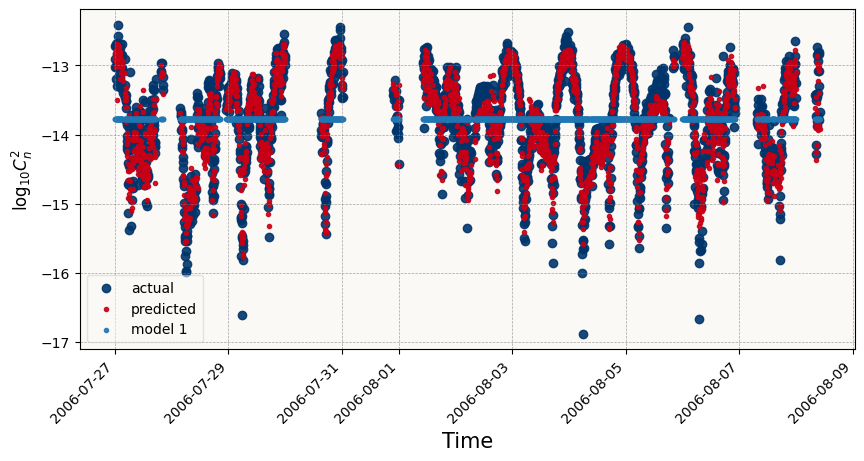

In [22]:
fig, ax = plot_predictions(y_test, y_pred, y_pred_mean_model)

While the evaluation metrics for the task indicate that the `PersistanceRegressionModel` has higher prediction error than the LightGBM model, the plot illustrates the qualitative difference between the two models. The `PersistanceRegressionModel` predicts the mean value seen during training, while the LightGBM model is able to capture the trends in the data.

We can also develop models under popular machine learning frameworks such as PyTorch and TensorFlow. The `otb` package includes a `PyTorchModel` class which can be used to develop PyTorch models for the tasks defined in the `otb.tasks` module.

In [49]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

We provide a sample implementation for a recurrent neural network model.

In [50]:
X_train, y_train = task.get_train_data(data_type="pd")
X_test, y_test = task.get_test_data(data_type="pd")

X, y = pd.concat([X_train, X_test]), pd.concat([y_train, y_test])

Define a recurrent neural network (RNN) model as a `PyTorch` module

In [51]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, _ = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out


In [52]:
class RNNModel:

    def __init__(
        self,
        name: str,
        input_size: int,
        obs_window_size: int = 1,
        hidden_size: int = 512,
        num_layers: int = 2,
        num_classes: int = 1,
        batch_size: int = 32,
        n_epochs: int = 500,
        learning_rate: float = 0.025,
        criterion: 'torch.nn.modules.loss' = nn.MSELoss(),
        optimizer: 'torch.optim' = optim.Adam,
        random_state: int = 2020,
        **kwargs
    ):
        self.name = name

        # persist the mean and std of the training data
        self.X_mean = None
        self.X_std = None
        self.y_mean = None
        self.y_std = None
        self.obs_window_size = obs_window_size

        # create the model
        self.batch_size = batch_size
        self.random_state = random_state
        self.model = RNN(input_size, hidden_size, num_layers, num_classes)
        self.n_epochs = n_epochs
        self.criterion = criterion
        self.optimizer = optimizer(self.model.parameters(), lr=learning_rate)
    
    def train(self, X: 'pd.DataFrame', y: 'pd.DataFrame'):
        # maintain the same interface as the other models
        n_features = len(X.columns)

        # map X and y to numpy arrays
        X = X.to_numpy()
        y = y.to_numpy()

        # normalize the training data
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        y_mean = y.mean(axis=0)
        y_std = y.std(axis=0)

        # save the mean and std
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std

        # normalize the data before training
        X = (X - X_mean) / X_std
        y = (y - y_mean) / y_std

        # convert to torch tensors
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)

        # create the dataset and dataloader
        train_dataset = torch.utils.data.TensorDataset(X, y)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        # train the model
        torch.manual_seed(self.random_state)
        for epoch in range(self.n_epochs):
            for _, (X, y) in enumerate(train_loader):
                X = X.reshape(-1, self.obs_window_size, n_features)  # correct for shape
                self.optimizer.zero_grad()
                outputs = self.model(X.float())
                loss = self.criterion(outputs, y.float())
                loss.backward()
                self.optimizer.step()
            if epoch % (self.n_epochs // 10) == 0:
                print(f"epoch: {epoch}, loss: {loss.item()}")

    def predict(self, X: 'pd.DataFrame'):
        # predict the mean for each entry in X
        n_features = len(X.columns)
        
        # map X to numpy array
        X = X.to_numpy()
        
        X = (X - self.X_mean) / self.X_std
        y = np.ones((X.shape[0], 1)) * self.y_mean
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)

        test_dataset = torch.utils.data.TensorDataset(X, y)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
        
        pred = []

        with torch.no_grad():
            for _, (X, _) in enumerate(test_loader):
                X = X.reshape(-1, self.obs_window_size, n_features)
                y_pred = self.model(X.float())
                y_pred = y_pred * self.y_std + self.y_mean
                y_pred = y_pred.numpy()

                # add the prediction value to the list
                pred.append(y_pred[0][0])
        
        return np.array(pred)


In [53]:
rnn_model = RNNModel(
    name="rnn",
    input_size = len(X.columns),
    obs_window_size = 1,
    hidden_size = 512,
    num_layers = 2,
    num_classes = 1,
    batch_size = 32,
    n_epochs = 800,
    learning_rate = 0.025,
    criterion = nn.MSELoss(),
    optimizer = optim.Adam,
    random_state = 2020,    
)

In [54]:
rnn_model.train(X, y)

epoch: 0, loss: 0.4756123423576355
epoch: 80, loss: 0.510210394859314
epoch: 160, loss: 0.28231561183929443
epoch: 240, loss: 0.4321051836013794
epoch: 320, loss: 0.3989618122577667
epoch: 400, loss: 0.5078237056732178
epoch: 480, loss: 0.6300228238105774
epoch: 560, loss: 0.2726720869541168
epoch: 640, loss: 0.7145797610282898
epoch: 720, loss: 0.24615336954593658


In [55]:
_, y_pred = task.evaluate_model(rnn_model.predict, return_predictions=True)

Compare with validation data

In [56]:
_, y_val = task.get_val_data(data_type="pd")

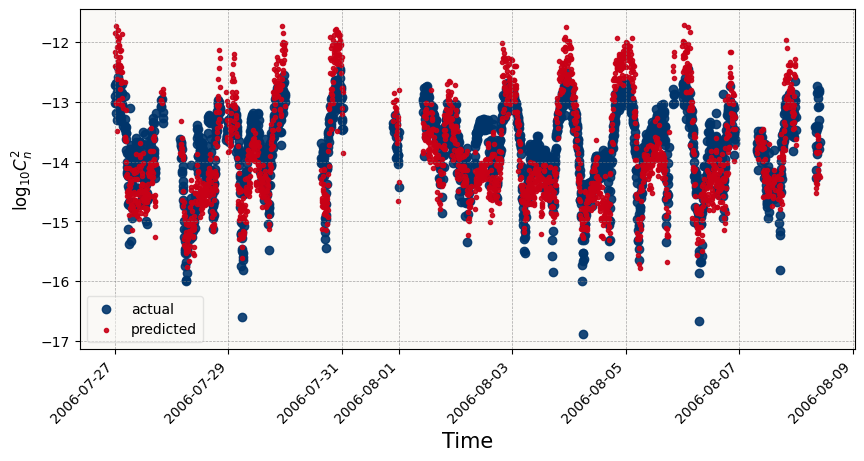

In [57]:
fig, ax = plot_predictions(y_test, y_pred)

We can use the same evaluation methods as before to compare the performance of the RNN model with the existing benchmarks.

In [58]:
task.evaluate_model(
        predict_call=rnn_model.predict,
        include_as_benchmark=True,
        model_name=rnn_model.name,
    )

{'root_mean_square_error': {'metric_value': 0.5144692063331604,
  'valid_predictions': 2449},
 'r2_score': {'metric_value': 0.3936416021006014, 'valid_predictions': 2449},
 'mean_absolute_error': {'metric_value': 0.42937517166137695,
  'valid_predictions': 2449},
 'mean_absolute_percentage_error': {'metric_value': 0.031436413526535034,
  'valid_predictions': 2449}}

In [59]:
top_5_models = task.top_models(n=5, metric="mean_absolute_percentage_error")

In [60]:
pprinter.pprint(top_5_models)

{   'ClimatologyRegressionModel': {   'mean_absolute_error': {   'metric_value': 0.5308192372322083,
                                                                 'valid_predictions': 2449},
                                      'mean_absolute_percentage_error': {   'metric_value': 0.038418691605329514,
                                                                            'valid_predictions': 2449},
                                      'r2_score': {'metric_value': -0.001476310741173048, 'valid_predictions': 2449},
                                      'root_mean_square_error': {   'metric_value': 0.6611728668212891,
                                                                    'valid_predictions': 2449}},
    'GradientBoostingRegressionModel': {   'mean_absolute_error': {   'metric_value': 0.15414540847947156,
                                                                      'valid_predictions': 2449},
                                           'mean_absolute_percen